In [15]:
import matplotlib.pyplot as plt
import rtlsdr
import numpy as np
import time
import pandas as pd
from datetime import datetime
from scipy import signal
import os
from sklearn.metrics import mean_squared_error



def hacer_potencia(psd_max):
    potencia=10*np.log10(psd_max)
    return potencia


def setup(f_min, f_max,veces):
    #Frecuency range and step
   
    rate_best = 2.4e6
    df = rate_best


    # Set up the scan
    freqs = np.arange(f_min + df/2.,f_max,df)
    nfreq = freqs.shape[0]  
    npsd_res = 1024
    npsd_avg = 256
    nsamp = npsd_res*npsd_avg
    nfreq_spec = nfreq*npsd_res 
    samples = np.zeros([nsamp,nfreq],dtype='complex128') 

    #Setting the data lists 
    psd_array = np.zeros([npsd_res,nfreq])
    freq_array = np.zeros([npsd_res,nfreq])
    #time_array = np.zeros([npsd_res,nfreq],dtype='datetime64[s]')
    relative_power_array = np.zeros([npsd_res,nfreq])


    #Configuracion de dataframes para el MAXHOLD
    len=freq_array.shape[0]
    
    psd_total=np.empty([len*14,veces])

    return rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total


def readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces):
    #Initializing SDR
    sdr = rtlsdr.RtlSdr()
    sdr.sample_rate = rate_best
    sdr.gain = 0
    samp_rate = sdr.sample_rate 
    for k in range(veces):
        for i,freq in enumerate(freqs):
                sdr.center_freq = freq
                samples[:,i] = sdr.read_samples(nsamp)
    for i,freq in enumerate(freqs):   
        fc_mhz = freq/1e6
        bw_mhz = sdr.sample_rate/1e6  
        psd_array[:,i],freq_array[:,i] = plt.psd(samples[:,i], NFFT=npsd_res, Fs=bw_mhz, Fc=fc_mhz)
    #print(psd_array)
    freq_series=np.concatenate(freq_array)
    psd_series=np.concatenate(psd_array)
    #print(k)
    #psd=pd.DataFrame(psd_series)
    #psd_total=np.reshape(len(psd_series),1)
    #print(psd_total.shape)
    psd_total=np.insert(psd_total,k,psd_series,axis=1)

    sdr.close()

    psd_total=pd.DataFrame(psd_total)
    psd_new=psd_total.loc[:,0:veces-1]
    psd_max=psd_new.max(axis=1)

    max_hold=psd_max.apply(hacer_potencia)
    data_array = np.stack((freq_series, max_hold), axis=1)
    df=pd.DataFrame(data_array,columns=['Frecuencia','Potencia'])
    data= df.sort_values('Frecuencia',ascending=True)
    
    return data

def canal_filter(data,f_min_canal,f_max_canal):
    data_canal=data[(data['Frecuencia']>=f_min_canal) & (data['Frecuencia']<=f_max_canal)]
    data_canal=data_canal.reset_index(drop=True)
    return data_canal

def minima_senal_detectable(num):
    return num


def detection_limit(n,umbral,constante):
    if n <= umbral: 
        return constante
    else:
        return n


def make_two_datafarme_same_size(senal_referencia,senal_comparacion):
    if len(senal_referencia)>len(senal_comparacion):
        return senal_referencia[0:len(senal_comparacion)]
    elif len(senal_referencia)<len(senal_comparacion):
        return senal_comparacion[0:len(senal_referencia)]
    else:
        return senal_referencia


def comparacion(senal_referencia,senal_comparacion):

    senal_referencia=make_two_datafarme_same_size(senal_referencia,senal_comparacion)
    corr=senal_referencia.corr(senal_comparacion)
    corr_validation=np.isnan(corr)
    if corr_validation==True:
        corr=0.2
    rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)

    if rmse > 10:
        rmse_list=[]
        for i in range(50):
            rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)
            rmse_list.append(rmse)
        rmse=min(rmse_list)
    return corr,rmse


def minimun_signal_detectable(dict,data):
    for key in dict:
        values=dict[key]
        condicicon=values[2]
        if condicicon=='libre':
            data_canal=canal_filter(data,values[0],values[1])
            if data_canal['Potencia'].max() < -25:
                umbral = data_canal['Potencia'].max()
                senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
                
    #print('El umbral es: '+ str(umbral)+' dBm'+' del '+str(key))
    return umbral, senal_referencia   

    
def signal_coherence(senal_referencia,senal_comparacion):
    f, Cxy = signal.coherence(senal_referencia,senal_comparacion)
    return Cxy


def run(data,f_min_canal,f_max_canal,umbral,senal_referencia):
    data_canal=canal_filter(data,f_min_canal,f_max_canal)
    #umbral=data_canal['Potencia'].max()
    #senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
    senal_comparacion=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))

    if senal_comparacion.shape[0] != senal_referencia.shape[0]:
        senal_comparacion=senal_comparacion[0:senal_referencia.shape[0]]
    
    corr,rmse = comparacion(senal_referencia,senal_comparacion)     #compararmos la senal con la misma solo para probar 
    #coherencia = signal_coherence(senal_referencia,senal_comparacion)
    return corr, data_canal,rmse

def procesamiento(f_min,f_max,canales):
    veces=50
    rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total= setup(f_min, f_max,veces)
    data=readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces)
    umbral,senal_referencia=minimun_signal_detectable(canales,data)

    for key in canales:
        values=canales[key]
        condicicon=values[2]
        if condicicon=='libre':
            
            f_min_canal=values[0]
            f_max_canal=values[1]

            corr,data_canal,rmse=run(data,f_min_canal,f_max_canal,umbral,senal_referencia)
            #print('El rmse es: '+ str(rmse))
            #print('La correlacion es ' + str(corr))
            maxim=data_canal['Potencia'].max()
            idmax=data_canal['Potencia'].idxmax()
            parasita = data_canal.loc[idmax]
            max_freq=parasita['Frecuencia']
            max_pot=parasita['Potencia']
            print(parasita)
            print(max_freq)
            print(max_pot)
            espuria={
                    'Frecuencia':max_freq,
                    'Potencia':max_pot,
                    }
            print(espuria)
            #par=parasita.to_dict()
            #print(par)
            if corr < 0.5 and rmse > 10 :
                maxim=data_canal['Potencia'].max()
                idmax=data_canal['Potencia'].idxmax()
                #print(rmse)
                if maxim > -20 and maxim < 200:
                    parasita = data_canal.loc[idmax]
                    max_freq=parasita['Frecuencia']
                    max_pot=parasita['Potencia']
                    print(parasita)
                    print(max_freq)
                    print(max_pot)
                    espuria={
                        'Frecuencia':max_freq,
                         'Potencia':max_pot,
                    }
                    return data, espuria , 1 #El 1 indica que se encontro una espuria
                    #Para la app web mandas un diccionario con 1 si hay una frecuencia parasita y el valor de la frecuencia y 0 si no hay frecuencia parasita
            else:
                print('No hay interferencia en el ' + str(key))
    
    return data, espuria, 0 # El 0 indica que no se encontro una espuria

def procesamiento_diccionarios(datos):
    datos.set_index('Frecuencia',inplace=True)
    datos=datos.rename_axis('Frecuencia')
    datos_potencia = datos['Potencia'].tolist()
    datos=datos.to_dict(orient='split')
    del datos['columns']
    espectro = {
        'Frecuencia': datos['index'],
        'Potencia': datos_potencia,
    }
    return espectro
    


Frecuencia    54.234375
Potencia     -51.323513
Name: 100, dtype: float64
54.234375
-51.323513329182134
{'Frecuencia': 54.234375, 'Potencia': -51.323513329182134}
No hay interferencia en el canal 2 - Libre 1
Frecuencia    57.600000
Potencia     -31.047249
Name: 575, dtype: float64
57.6
-31.047248595986304
{'Frecuencia': 57.6, 'Potencia': -31.047248595986304}
No hay interferencia en el canal 2 - Libre 2
Frecuencia    59.299219
Potencia     -48.162454
Name: 20, dtype: float64
59.29921875
-48.1624535801706
{'Frecuencia': 59.29921875, 'Potencia': -48.1624535801706}
No hay interferencia en el canal 2 - Libre 3
Frecuencia    60.000000
Potencia     -31.125066
Name: 76, dtype: float64
60.0
-31.125066154493318
{'Frecuencia': 60.0, 'Potencia': -31.125066154493318}
No hay interferencia en el canal 2 - Libre 4
Frecuencia    60.002344
Potencia     -36.941782
Name: 0, dtype: float64
60.00234375
-36.94178175596478
{'Frecuencia': 60.00234375, 'Potencia': -36.94178175596478}
No hay interferencia en el 

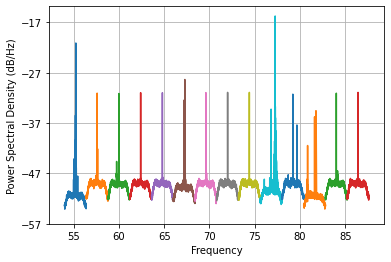

In [16]:

f_min = 54e6
f_max = 88e6
    
    
canales ={
        'canal 2 - Libre 1': [54.0000,54.249,'libre'],
        'canal 2 - Video': [54.250,56.250,'usado'],
        'canal 2 - Libre 2': [56.251,58.490,'libre'],
        'canal 2 - Armonicos': [58.50,59.250,'usado'],
        'canal 2 - Libre 3': [59.251,59.680,'libre'],
        'canal 2 - Audio': [59.69,59.81,'usado'],
        'canal 2 - Libre 4': [59.82,60.000,'libre'],
        
        'canal 3 - Libre 1': [60.0001,61.149,'libre'],
        'canal 3 - Armonicos': [61.150,61.50,'usado'],
        'canal 3 - Libre 2': [61.51,66.000,'libre'],


        'canal 4 - Libre 1': [66.001,66.7490,'libre'],
        'canal 4 - Video': [66.750,68.750,'usado'],
        'canal 4 - Libre 2': [68.751,70.749,'libre'],
        'canal 4 - Armonicos': [70.750,71.01,'usado'],
        'canal 4 - Libre 3': [71.02,71.70,'libre'],
        'canal 4 - Audio': [71.71,71.77,'usado'],
        'canal 4 - Libre 4':[71.78,72.00,'libre'],

        'canal 5 - Libre 1': [76.000,76.249,'libre'],
        'canal 5 - Video': [76.250,78.750,'usado'],
        'canal 5 - Libre 2': [78.751,80.249,'libre'],
        'canal 5 - Armonicos': [80.250,81.250,'usado'],
        'canal 5 - Libre 3': [81.251,81.68,'libre'],
        'canal 5 - Audio': [81.69,81.81,'usado'],
        'canal 5 - Libre 4': [81.82,82.00,'libre'],

        'canal 6 - Libre 1': [82.01,85.39,'libre'],
        'canal 6 - Armonicos': [85.40,85.60,'usado'],
        'canal 6 - Libre 2': [85.70,88.000,'libre'],
        }
    #Espectro: Diccionario con los datos de las frecuencias y sus Potencias
datos, espuria , descision =procesamiento(f_min,f_max,canales)      #descion = 1 hay espuria, 0 no hay espuria
    #espectro = procesamiento_diccionarios(datos)
print (datos)
    
    

Para los siguientes espectros necesito cambiar el digito (7) en el setup y crear un setup para cada iteracion. 

In [21]:
import matplotlib.pyplot as plt
import rtlsdr
import numpy as np
import time
import pandas as pd
from datetime import datetime
from scipy import signal
import os
from sklearn.metrics import mean_squared_error



def hacer_potencia(psd_max):
    potencia=10*np.log10(psd_max)
    return potencia


def setup(f_min, f_max,veces):
    #Frecuency range and step
   
    rate_best = 2.4e6
    df = rate_best


    # Set up the scan
    freqs = np.arange(f_min + df/2.,f_max,df)
    nfreq = freqs.shape[0]  
    npsd_res = 1024
    npsd_avg = 256
    nsamp = npsd_res*npsd_avg
    nfreq_spec = nfreq*npsd_res 
    samples = np.zeros([nsamp,nfreq],dtype='complex128') 

    #Setting the data lists 
    psd_array = np.zeros([npsd_res,nfreq])
    freq_array = np.zeros([npsd_res,nfreq])
    #time_array = np.zeros([npsd_res,nfreq],dtype='datetime64[s]')
    relative_power_array = np.zeros([npsd_res,nfreq])


    #Configuracion de dataframes para el MAXHOLD
    len=freq_array.shape[0]
    
    psd_total=np.empty([len*17,veces])

    return rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total


def readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces):
    #Initializing SDR
    sdr = rtlsdr.RtlSdr()
    sdr.sample_rate = rate_best
    sdr.gain = 0
    samp_rate = sdr.sample_rate 
    for k in range(veces):
        for i,freq in enumerate(freqs):
                sdr.center_freq = freq
                samples[:,i] = sdr.read_samples(nsamp)
    for i,freq in enumerate(freqs):   
        fc_mhz = freq/1e6
        bw_mhz = sdr.sample_rate/1e6  
        psd_array[:,i],freq_array[:,i] = plt.psd(samples[:,i], NFFT=npsd_res, Fs=bw_mhz, Fc=fc_mhz)
    #print(psd_array)
    freq_series=np.concatenate(freq_array)
    psd_series=np.concatenate(psd_array)
    #print(k)
    #psd=pd.DataFrame(psd_series)
    #psd_total=np.reshape(len(psd_series),1)
    #print(psd_total.shape)
    psd_total=np.insert(psd_total,k,psd_series,axis=1)

    sdr.close()

    psd_total=pd.DataFrame(psd_total)
    psd_new=psd_total.loc[:,0:veces-1]
    psd_max=psd_new.max(axis=1)

    max_hold=psd_max.apply(hacer_potencia)
    data_array = np.stack((freq_series, max_hold), axis=1)
    df=pd.DataFrame(data_array,columns=['Frecuencia','Potencia'])
    data= df.sort_values('Frecuencia',ascending=True)
    
    return data

def canal_filter(data,f_min_canal,f_max_canal):
    data_canal=data[(data['Frecuencia']>=f_min_canal) & (data['Frecuencia']<=f_max_canal)]
    data_canal=data_canal.reset_index(drop=True)
    return data_canal

def minima_senal_detectable(num):
    return num


def detection_limit(n,umbral,constante):
    if n <= umbral: 
        return constante
    else:
        return n


def make_two_datafarme_same_size(senal_referencia,senal_comparacion):
    if len(senal_referencia)>len(senal_comparacion):
        return senal_referencia[0:len(senal_comparacion)]
    elif len(senal_referencia)<len(senal_comparacion):
        return senal_comparacion[0:len(senal_referencia)]
    else:
        return senal_referencia


def comparacion(senal_referencia,senal_comparacion):

    senal_referencia=make_two_datafarme_same_size(senal_referencia,senal_comparacion)
    corr=senal_referencia.corr(senal_comparacion)
    corr_validation=np.isnan(corr)
    if corr_validation==True:
        corr=0.2
    rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)

    if rmse > 10:
        rmse_list=[]
        for i in range(50):
            rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)
            rmse_list.append(rmse)
        rmse=min(rmse_list)
    return corr,rmse


def minimun_signal_detectable(dict,data):
    for key in dict:
        values=dict[key]
        condicicon=values[2]
        if condicicon=='libre':
            data_canal=canal_filter(data,values[0],values[1])
            if data_canal['Potencia'].max() < -25:
                umbral = data_canal['Potencia'].max()
                senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
                
    #print('El umbral es: '+ str(umbral)+' dBm'+' del '+str(key))
    return umbral, senal_referencia   

    
def signal_coherence(senal_referencia,senal_comparacion):
    f, Cxy = signal.coherence(senal_referencia,senal_comparacion)
    return Cxy


def run(data,f_min_canal,f_max_canal,umbral,senal_referencia):
    data_canal=canal_filter(data,f_min_canal,f_max_canal)
    #umbral=data_canal['Potencia'].max()
    #senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
    senal_comparacion=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))

    if senal_comparacion.shape[0] != senal_referencia.shape[0]:
        senal_comparacion=senal_comparacion[0:senal_referencia.shape[0]]
    
    corr,rmse = comparacion(senal_referencia,senal_comparacion)     #compararmos la senal con la misma solo para probar 
    #coherencia = signal_coherence(senal_referencia,senal_comparacion)
    return corr, data_canal,rmse

def procesamiento(f_min,f_max,canales):
    veces=50
    rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total= setup(f_min, f_max,veces)
    data=readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces)
    umbral,senal_referencia=minimun_signal_detectable(canales,data)

    for key in canales:
        values=canales[key]
        condicicon=values[2]
        if condicicon=='libre':
            
            f_min_canal=values[0]
            f_max_canal=values[1]

            corr,data_canal,rmse=run(data,f_min_canal,f_max_canal,umbral,senal_referencia)
            #print('El rmse es: '+ str(rmse))
            #print('La correlacion es ' + str(corr))
            maxim=data_canal['Potencia'].max()
            idmax=data_canal['Potencia'].idxmax()
            parasita = data_canal.loc[idmax]
            max_freq=parasita['Frecuencia']
            max_pot=parasita['Potencia']
            print(parasita)
            print(max_freq)
            print(max_pot)
            espuria={
                    'Frecuencia':max_freq,
                    'Potencia':max_pot,
                    }
            print(espuria)
            #par=parasita.to_dict()
            #print(par)
            if corr < 0.5 and rmse > 10 :
                maxim=data_canal['Potencia'].max()
                idmax=data_canal['Potencia'].idxmax()
                #print(rmse)
                if maxim > -20 and maxim < 200:
                    parasita = data_canal.loc[idmax]
                    max_freq=parasita['Frecuencia']
                    max_pot=parasita['Potencia']
                    print(parasita)
                    print(max_freq)
                    print(max_pot)
                    espuria={
                        'Frecuencia':max_freq,
                         'Potencia':max_pot,
                    }
                    return data, espuria , 1 #El 1 indica que se encontro una espuria
                    #Para la app web mandas un diccionario con 1 si hay una frecuencia parasita y el valor de la frecuencia y 0 si no hay frecuencia parasita
            else:
                print('No hay interferencia en el ' + str(key))
    
    return data, espuria, 0 # El 0 indica que no se encontro una espuria

def procesamiento_diccionarios(datos):
    datos.set_index('Frecuencia',inplace=True)
    datos=datos.rename_axis('Frecuencia')
    datos_potencia = datos['Potencia'].tolist()
    datos=datos.to_dict(orient='split')
    del datos['columns']
    espectro = {
        'Frecuencia': datos['index'],
        'Potencia': datos_potencia,
    }
    return espectro
    

Frecuencia    175.20000
Potencia      -30.82409
Name: 512, dtype: float64
175.2
-30.824090000965292
{'Frecuencia': 175.2, 'Potencia': -30.824090000965292}
No hay interferencia en el canal 7 - Libre 1
Frecuencia    180.044531
Potencia      -48.272276
Name: 14, dtype: float64
180.04453125
-48.27227553729807
{'Frecuencia': 180.04453125, 'Potencia': -48.27227553729807}
No hay interferencia en el canal 8 - Libre 1
Frecuencia    182.400000
Potencia      -31.235885
Name: 59, dtype: float64
182.4
-31.23588506351981
{'Frecuencia': 182.4, 'Potencia': -31.23588506351981}
No hay interferencia en el canal 8 - Libre 2
Frecuencia    185.524219
Potencia      -49.021443
Name: 112, dtype: float64
185.52421875000002
-49.0214425668841
{'Frecuencia': 185.52421875000002, 'Potencia': -49.0214425668841}
No hay interferencia en el canal 8 - Libre 3
Frecuencia    185.8500
Potencia      -50.6518
Name: 12, dtype: float64
185.85000000000002
-50.65180020188026
{'Frecuencia': 185.85000000000002, 'Potencia': -50.6518

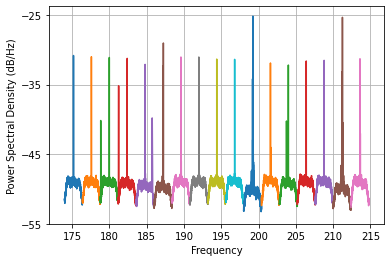

In [23]:
f_min = 174e6
f_max = 216e6

canales ={

        'canal 7 - Libre 1': [174.00,180.00,'libre'],

        'canal 8 - Libre 1': [180.01,180.49,'libre'],
        'canal 8 - Video': [180.50,182.250,'usado'],
        'canal 8 - Libre 2': [182.26,184.49,'libre'],
        'canal 8 - Armonicos': [184.50,185.250,'usado'],
        'canal 8 - Libre 3': [185.26,185.68,'libre'],
        'canal 8 - Audio': [185.69,185.81,'usado'],
        'canal 8 - Libre 4': [185.82,186.00,'libre'],

        'canal 9 - Libre 1': [186.01,186.99,'libre'],
        'canal 9 - Video': [187.00,187.50,'usado'],
        'canal 9 - Libre 2': [187.60,190.5,'libre'],
        'canal 9 - Armonicos': [190.60,191.00,'usado'],
        'canal 9 - Libre 3': [191.01,191.68,'libre'],
        'canal 9 - Audio': [191.69,191.81,'usado'],
        'canal 9 - Libre 4': [191.82,192.00,'libre'],
    
        'canal 10 - Libre 1': [192.01,198.00,'libre'],

        'canal 11 - Libre 1': [198.01,198.99,'libre'],
        'canal 11 - Video': [199.00,199.750,'usado'],
        'canal 11 - Libre 2': [199.76,202.74,'libre'],
        'canal 11 - Armonicos': [202.75,203.00,'usado'],
        'canal 11 - Libre 3': [203.01,203.68,'libre'],
        'canal 11 - Audio': [203.69,203.81,'usado'],
        'canal 11 - Libre 4': [203.82,204.00,'libre'],

        'canal 12 - Libre 1': [204.01,210.00,'libre'],

        'canal 13 - Libre 1': [210.01,210.749,'libre'],
        'canal 13 - Video': [210.75,212.00,'usado'],
        'canal 13 - Libre 2': [212.01,214.6,'libre'],
        'canal 13 - Armonicos': [214.7,215.10,'usado'],
        #'canal 13 - Libre 3': [215.20,215.67,'libre'],
        'canal 13 - Audio': [215.68,215.81,'usado'],
        #'canal 13 - Libre 4': [215.82,216.00,'libre'],

        } 
    
    #Espectro: Diccionario con los datos de las frecuencias y sus Potencias
datos, espuria , descision =procesamiento(f_min,f_max,canales)      #descion = 1 hay espuria, 0 no hay espuria
    #espectro = procesamiento_diccionarios(datos)
print (datos)

In [27]:
import matplotlib.pyplot as plt
import rtlsdr
import numpy as np
import time
import pandas as pd
from datetime import datetime
from scipy import signal
import os
from sklearn.metrics import mean_squared_error



def hacer_potencia(psd_max):
    potencia=10*np.log10(psd_max)
    return potencia


def setup(f_min, f_max,veces):
    #Frecuency range and step
   
    rate_best = 2.4e6
    df = rate_best


    # Set up the scan
    freqs = np.arange(f_min + df/2.,f_max,df)
    nfreq = freqs.shape[0]  
    npsd_res = 1024
    npsd_avg = 256
    nsamp = npsd_res*npsd_avg
    nfreq_spec = nfreq*npsd_res 
    samples = np.zeros([nsamp,nfreq],dtype='complex128') 

    #Setting the data lists 
    psd_array = np.zeros([npsd_res,nfreq])
    freq_array = np.zeros([npsd_res,nfreq])
    #time_array = np.zeros([npsd_res,nfreq],dtype='datetime64[s]')
    relative_power_array = np.zeros([npsd_res,nfreq])


    #Configuracion de dataframes para el MAXHOLD
    len=freq_array.shape[0]
    
    psd_total=np.empty([len*30,veces])

    return rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total


def readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces):
    #Initializing SDR
    sdr = rtlsdr.RtlSdr()
    sdr.sample_rate = rate_best
    sdr.gain = 0
    samp_rate = sdr.sample_rate 
    for k in range(veces):
        for i,freq in enumerate(freqs):
                sdr.center_freq = freq
                samples[:,i] = sdr.read_samples(nsamp)
    for i,freq in enumerate(freqs):   
        fc_mhz = freq/1e6
        bw_mhz = sdr.sample_rate/1e6  
        psd_array[:,i],freq_array[:,i] = plt.psd(samples[:,i], NFFT=npsd_res, Fs=bw_mhz, Fc=fc_mhz)
    #print(psd_array)
    freq_series=np.concatenate(freq_array)
    psd_series=np.concatenate(psd_array)
    #print(k)
    #psd=pd.DataFrame(psd_series)
    #psd_total=np.reshape(len(psd_series),1)
    #print(psd_total.shape)
    psd_total=np.insert(psd_total,k,psd_series,axis=1)

    sdr.close()

    psd_total=pd.DataFrame(psd_total)
    psd_new=psd_total.loc[:,0:veces-1]
    psd_max=psd_new.max(axis=1)

    max_hold=psd_max.apply(hacer_potencia)
    data_array = np.stack((freq_series, max_hold), axis=1)
    df=pd.DataFrame(data_array,columns=['Frecuencia','Potencia'])
    data= df.sort_values('Frecuencia',ascending=True)
    
    return data

def canal_filter(data,f_min_canal,f_max_canal):
    data_canal=data[(data['Frecuencia']>=f_min_canal) & (data['Frecuencia']<=f_max_canal)]
    data_canal=data_canal.reset_index(drop=True)
    return data_canal

def minima_senal_detectable(num):
    return num


def detection_limit(n,umbral,constante):
    if n <= umbral: 
        return constante
    else:
        return n


def make_two_datafarme_same_size(senal_referencia,senal_comparacion):
    if len(senal_referencia)>len(senal_comparacion):
        return senal_referencia[0:len(senal_comparacion)]
    elif len(senal_referencia)<len(senal_comparacion):
        return senal_comparacion[0:len(senal_referencia)]
    else:
        return senal_referencia


def comparacion(senal_referencia,senal_comparacion):

    senal_referencia=make_two_datafarme_same_size(senal_referencia,senal_comparacion)
    corr=senal_referencia.corr(senal_comparacion)
    corr_validation=np.isnan(corr)
    if corr_validation==True:
        corr=0.2
    rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)

    if rmse > 10:
        rmse_list=[]
        for i in range(50):
            rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)
            rmse_list.append(rmse)
        rmse=min(rmse_list)
    return corr,rmse


def minimun_signal_detectable(dict,data):
    for key in dict:
        values=dict[key]
        condicicon=values[2]
        if condicicon=='libre':
            data_canal=canal_filter(data,values[0],values[1])
            if data_canal['Potencia'].max() < -25:
                umbral = data_canal['Potencia'].max()
                senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
                
    #print('El umbral es: '+ str(umbral)+' dBm'+' del '+str(key))
    return umbral, senal_referencia   

    
def signal_coherence(senal_referencia,senal_comparacion):
    f, Cxy = signal.coherence(senal_referencia,senal_comparacion)
    return Cxy


def run(data,f_min_canal,f_max_canal,umbral,senal_referencia):
    data_canal=canal_filter(data,f_min_canal,f_max_canal)
    #umbral=data_canal['Potencia'].max()
    #senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
    senal_comparacion=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))

    if senal_comparacion.shape[0] != senal_referencia.shape[0]:
        senal_comparacion=senal_comparacion[0:senal_referencia.shape[0]]
    
    corr,rmse = comparacion(senal_referencia,senal_comparacion)     #compararmos la senal con la misma solo para probar 
    #coherencia = signal_coherence(senal_referencia,senal_comparacion)
    return corr, data_canal,rmse

def procesamiento(f_min,f_max,canales):
    veces=50
    rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total= setup(f_min, f_max,veces)
    data=readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces)
    umbral,senal_referencia=minimun_signal_detectable(canales,data)

    for key in canales:
        values=canales[key]
        condicicon=values[2]
        if condicicon=='libre':
            
            f_min_canal=values[0]
            f_max_canal=values[1]

            corr,data_canal,rmse=run(data,f_min_canal,f_max_canal,umbral,senal_referencia)
            #print('El rmse es: '+ str(rmse))
            #print('La correlacion es ' + str(corr))
            maxim=data_canal['Potencia'].max()
            idmax=data_canal['Potencia'].idxmax()
            parasita = data_canal.loc[idmax]
            max_freq=parasita['Frecuencia']
            max_pot=parasita['Potencia']
            print(parasita)
            print(max_freq)
            print(max_pot)
            espuria={
                    'Frecuencia':max_freq,
                    'Potencia':max_pot,
                    }
            print(espuria)
            #par=parasita.to_dict()
            #print(par)
            if corr < 0.5 and rmse > 10 :
                maxim=data_canal['Potencia'].max()
                idmax=data_canal['Potencia'].idxmax()
                #print(rmse)
                if maxim > -20 and maxim < 200:
                    parasita = data_canal.loc[idmax]
                    max_freq=parasita['Frecuencia']
                    max_pot=parasita['Potencia']
                    print(parasita)
                    print(max_freq)
                    print(max_pot)
                    espuria={
                        'Frecuencia':max_freq,
                         'Potencia':max_pot,
                    }
                    return data, espuria , 1 #El 1 indica que se encontro una espuria
                    #Para la app web mandas un diccionario con 1 si hay una frecuencia parasita y el valor de la frecuencia y 0 si no hay frecuencia parasita
            else:
                print('No hay interferencia en el ' + str(key))
    
    return data, espuria, 0 # El 0 indica que no se encontro una espuria

def procesamiento_diccionarios(datos):
    datos.set_index('Frecuencia',inplace=True)
    datos=datos.rename_axis('Frecuencia')
    datos_potencia = datos['Potencia'].tolist()
    datos=datos.to_dict(orient='split')
    del datos['columns']
    espectro = {
        'Frecuencia': datos['index'],
        'Potencia': datos_potencia,
    }
    return espectro
    

Frecuencia    500.009375
Potencia      -51.539613
Name: 4, dtype: float64
500.009375
-51.539612846329135
{'Frecuencia': 500.009375, 'Potencia': -51.539612846329135}
No hay interferencia en el canal 19 - Libre 1
Frecuencia    503.600000
Potencia      -30.814629
Name: 1425, dtype: float64
503.6
-30.81462883215536
{'Frecuencia': 503.6, 'Potencia': -30.81462883215536}
No hay interferencia en el canal 19 - Libre 2
Frecuencia    508.400000
Potencia      -30.799551
Name: 1019, dtype: float64
508.4
-30.799551385204875
{'Frecuencia': 508.4, 'Potencia': -30.799551385204875}
No hay interferencia en el canal 20 - Libre 1
Frecuencia    512.407813
Potencia      -48.247541
Name: 169, dtype: float64
512.4078125000001
-48.247541186281275
{'Frecuencia': 512.4078125000001, 'Potencia': -48.247541186281275}
No hay interferencia en el canal 21 - Libre 1
Frecuencia    515.600000
Potencia      -30.815317
Name: 785, dtype: float64
515.6
-30.81531717550245
{'Frecuencia': 515.6, 'Potencia': -30.81531717550245}
N

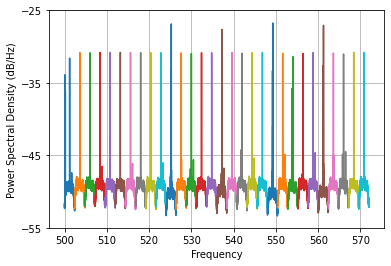

In [28]:
f_min = 500e6
f_max = 572e6

    
canales ={

        'canal 19 - Libre 1': [500.00,500.04,'libre'],
        'canal 19 - Armonicos': [500.05,500.25,'usado'],
        'canal 19 - Libre 2': [500.26,506.000,'libre'],

        'canal 20 - Libre 1': [506.01,512.00,'libre'],

        'canal 21 - Libre 1': [512.01,512.49,'libre'],
        'canal 21 - Armonicos': [512.5,513.75,'usado'],
        'canal 21 - Libre 2': [513.76,518.000,'libre'],

        'canal 22 - Libre 1': [518.01,518.349,'libre'],
        'canal 22 - Armonicos': [518.35,518.45,'usado'],
        'canal 22 - Libre 2': [518.46,524.000,'libre'],

        'canal 23 - Libre 1': [524.01,524.49,'libre'],
        'canal 23 - Video': [524.5,526.50,'usado'],
        'canal 23 - Libre 2': [526.6,528.49,'libre'],
        'canal 23 - Armonicos': [528.5,529.125,'usado'],
        'canal 23 - Libre 3': [529.13,529.6,'libre'],
        'canal 23 - Audio': [529.625,529.85,'usado'],
        'canal 23 - Libre 4': [529.86,530.00,'libre'],

        'canal 24 - Libre 1': [530.01,532.774,'libre'],
        'canal 24 - Armonicos': [532.775,532.85,'usado'],
        'canal 24 - Libre 2': [532.86,536.000,'libre'],
    
        'canal 25 - Libre 1': [536.01,536.249,'libre'],
        'canal 25 - Video': [536.250,538.250,'usado'],
        'canal 25 - Libre 2': [538.26,540.49,'libre'],
        'canal 25 - Armonicos': [540.5,541.250,'usado'],
        'canal 25 - Libre 3': [541.260,541.64,'libre'],
        'canal 25 - Audio': [541.65,541.825,'usado'],
        'canal 25 - Libre 4': [541.83,542.00,'libre'],

        'canal 26 - Libre 1': [542.01,547.174,'libre'],
        'canal 26 - Armonicos': [547.175,547.225,'usado'],
        'canal 26 - Libre 2': [547.226,548.000,'libre'],

        'canal 27- Libre 1': [548.01,548.249,'libre'],
        'canal 27 - Video': [548.250,550.50,'usado'],
        'canal 27 - Libre 2': [550.60,552.49,'libre'],
        'canal 27 - Armonicos': [552.5,553.250,'usado'],
        'canal 27 - Libre 3': [553.260,553.64,'libre'],
        'canal 27 - Audio': [553.65,553.875,'usado'],
        'canal 27 - Libre 4': [553.88,554.00,'libre'],

        'canal 28 - Libre 1': [554.01,560.00,'libre'],

        'canal 29- Libre 1': [560.01,560.249,'libre'],
        'canal 29 - Video': [560.250,562.00,'usado'],
        'canal 29 - Libre 2': [562.01,564.49,'libre'],
        'canal 29 - Armonicos': [564.5,565.05,'usado'],
        'canal 29 - Libre 3': [565.06,565.67,'libre'],
        'canal 29 - Audio': [565.68,565.81,'usado'],
        'canal 29 - Libre 4': [565.82,566.00,'libre'],

        'canal 30 - Libre 1': [566.01,572.00,'libre'],
        }  
    #Espectro: Diccionario con los datos de las frecuencias y sus Potencias
datos, espuria , descision =procesamiento(f_min,f_max,canales)      #descion = 1 hay espuria, 0 no hay espuria
    #espectro = procesamiento_diccionarios(datos)
print (datos)

In [30]:
import matplotlib.pyplot as plt
import rtlsdr
import numpy as np
import time
import pandas as pd
from datetime import datetime
from scipy import signal
import os
from sklearn.metrics import mean_squared_error



def hacer_potencia(psd_max):
    potencia=10*np.log10(psd_max)
    return potencia


def setup(f_min, f_max,veces):
    #Frecuency range and step
   
    rate_best = 2.4e6
    df = rate_best


    # Set up the scan
    freqs = np.arange(f_min + df/2.,f_max,df)
    nfreq = freqs.shape[0]  
    npsd_res = 1024
    npsd_avg = 256
    nsamp = npsd_res*npsd_avg
    nfreq_spec = nfreq*npsd_res 
    samples = np.zeros([nsamp,nfreq],dtype='complex128') 

    #Setting the data lists 
    psd_array = np.zeros([npsd_res,nfreq])
    freq_array = np.zeros([npsd_res,nfreq])
    #time_array = np.zeros([npsd_res,nfreq],dtype='datetime64[s]')
    relative_power_array = np.zeros([npsd_res,nfreq])


    #Configuracion de dataframes para el MAXHOLD
    len=freq_array.shape[0]
    
    psd_total=np.empty([len*25,veces])

    return rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total


def readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces):
    #Initializing SDR
    sdr = rtlsdr.RtlSdr()
    sdr.sample_rate = rate_best
    sdr.gain = 0
    samp_rate = sdr.sample_rate 
    for k in range(veces):
        for i,freq in enumerate(freqs):
                sdr.center_freq = freq
                samples[:,i] = sdr.read_samples(nsamp)
    for i,freq in enumerate(freqs):   
        fc_mhz = freq/1e6
        bw_mhz = sdr.sample_rate/1e6  
        psd_array[:,i],freq_array[:,i] = plt.psd(samples[:,i], NFFT=npsd_res, Fs=bw_mhz, Fc=fc_mhz)
    #print(psd_array)
    freq_series=np.concatenate(freq_array)
    psd_series=np.concatenate(psd_array)
    #print(k)
    #psd=pd.DataFrame(psd_series)
    #psd_total=np.reshape(len(psd_series),1)
    #print(psd_total.shape)
    psd_total=np.insert(psd_total,k,psd_series,axis=1)

    sdr.close()

    psd_total=pd.DataFrame(psd_total)
    psd_new=psd_total.loc[:,0:veces-1]
    psd_max=psd_new.max(axis=1)

    max_hold=psd_max.apply(hacer_potencia)
    data_array = np.stack((freq_series, max_hold), axis=1)
    df=pd.DataFrame(data_array,columns=['Frecuencia','Potencia'])
    data= df.sort_values('Frecuencia',ascending=True)
    
    return data

def canal_filter(data,f_min_canal,f_max_canal):
    data_canal=data[(data['Frecuencia']>=f_min_canal) & (data['Frecuencia']<=f_max_canal)]
    data_canal=data_canal.reset_index(drop=True)
    return data_canal

def minima_senal_detectable(num):
    return num


def detection_limit(n,umbral,constante):
    if n <= umbral: 
        return constante
    else:
        return n


def make_two_datafarme_same_size(senal_referencia,senal_comparacion):
    if len(senal_referencia)>len(senal_comparacion):
        return senal_referencia[0:len(senal_comparacion)]
    elif len(senal_referencia)<len(senal_comparacion):
        return senal_comparacion[0:len(senal_referencia)]
    else:
        return senal_referencia


def comparacion(senal_referencia,senal_comparacion):

    senal_referencia=make_two_datafarme_same_size(senal_referencia,senal_comparacion)
    corr=senal_referencia.corr(senal_comparacion)
    corr_validation=np.isnan(corr)
    if corr_validation==True:
        corr=0.2
    rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)

    if rmse > 10:
        rmse_list=[]
        for i in range(50):
            rmse=mean_squared_error(senal_referencia,senal_comparacion,squared=True)
            rmse_list.append(rmse)
        rmse=min(rmse_list)
    return corr,rmse


def minimun_signal_detectable(dict,data):
    for key in dict:
        values=dict[key]
        condicicon=values[2]
        if condicicon=='libre':
            data_canal=canal_filter(data,values[0],values[1])
            if data_canal['Potencia'].max() < -25:
                umbral = data_canal['Potencia'].max()
                senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
                
    #print('El umbral es: '+ str(umbral)+' dBm'+' del '+str(key))
    return umbral, senal_referencia   

    
def signal_coherence(senal_referencia,senal_comparacion):
    f, Cxy = signal.coherence(senal_referencia,senal_comparacion)
    return Cxy


def run(data,f_min_canal,f_max_canal,umbral,senal_referencia):
    data_canal=canal_filter(data,f_min_canal,f_max_canal)
    #umbral=data_canal['Potencia'].max()
    #senal_referencia=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))
    senal_comparacion=data_canal['Potencia'].apply(detection_limit,args=(umbral,umbral))

    if senal_comparacion.shape[0] != senal_referencia.shape[0]:
        senal_comparacion=senal_comparacion[0:senal_referencia.shape[0]]
    
    corr,rmse = comparacion(senal_referencia,senal_comparacion)     #compararmos la senal con la misma solo para probar 
    #coherencia = signal_coherence(senal_referencia,senal_comparacion)
    return corr, data_canal,rmse

def procesamiento(f_min,f_max,canales):
    veces=50
    rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total= setup(f_min, f_max,veces)
    data=readsdr(rate_best, freqs, nfreq, npsd_res, npsd_avg, nsamp, nfreq_spec, samples, psd_array, freq_array, relative_power_array, psd_total,veces)
    umbral,senal_referencia=minimun_signal_detectable(canales,data)

    for key in canales:
        values=canales[key]
        condicicon=values[2]
        if condicicon=='libre':
            
            f_min_canal=values[0]
            f_max_canal=values[1]

            corr,data_canal,rmse=run(data,f_min_canal,f_max_canal,umbral,senal_referencia)
            #print('El rmse es: '+ str(rmse))
            #print('La correlacion es ' + str(corr))
            maxim=data_canal['Potencia'].max()
            idmax=data_canal['Potencia'].idxmax()
            parasita = data_canal.loc[idmax]
            max_freq=parasita['Frecuencia']
            max_pot=parasita['Potencia']
            print(parasita)
            print(max_freq)
            print(max_pot)
            espuria={
                    'Frecuencia':max_freq,
                    'Potencia':max_pot,
                    }
            print(espuria)
            #par=parasita.to_dict()
            #print(par)
            if corr < 0.5 and rmse > 10 :
                maxim=data_canal['Potencia'].max()
                idmax=data_canal['Potencia'].idxmax()
                #print(rmse)
                if maxim > -20 and maxim < 200:
                    parasita = data_canal.loc[idmax]
                    max_freq=parasita['Frecuencia']
                    max_pot=parasita['Potencia']
                    print(parasita)
                    print(max_freq)
                    print(max_pot)
                    espuria={
                        'Frecuencia':max_freq,
                         'Potencia':max_pot,
                    }
                    return data, espuria , 1 #El 1 indica que se encontro una espuria
                    #Para la app web mandas un diccionario con 1 si hay una frecuencia parasita y el valor de la frecuencia y 0 si no hay frecuencia parasita
            else:
                print('No hay interferencia en el ' + str(key))
    
    return data, espuria, 0 # El 0 indica que no se encontro una espuria

def procesamiento_diccionarios(datos):
    datos.set_index('Frecuencia',inplace=True)
    datos=datos.rename_axis('Frecuencia')
    datos_potencia = datos['Potencia'].tolist()
    datos=datos.to_dict(orient='split')
    del datos['columns']
    espectro = {
        'Frecuencia': datos['index'],
        'Potencia': datos_potencia,
    }
    return espectro

Frecuencia    572.442969
Potencia      -48.287598
Name: 184, dtype: float64
572.4429687500001
-48.28759812631222
{'Frecuencia': 572.4429687500001, 'Potencia': -48.28759812631222}
No hay interferencia en el canal 31 - Libre 1
Frecuencia    575.600000
Potencia      -30.798233
Name: 678, dtype: float64
575.6
-30.798232576837417
{'Frecuencia': 575.6, 'Potencia': -30.798232576837417}
No hay interferencia en el canal 31 - Libre 2
Frecuencia    575.600000
Potencia      -30.798233
Name: 128, dtype: float64
575.6
-30.798232576837417
{'Frecuencia': 575.6, 'Potencia': -30.798232576837417}
No hay interferencia en el canal 31 - Libre 3
Frecuencia    578.000000
Potencia      -30.856725
Name: 76, dtype: float64
578.0
-30.85672464572234
{'Frecuencia': 578.0, 'Potencia': -30.85672464572234}
No hay interferencia en el canal 31 - Libre 4
Frecuencia    582.800000
Potencia      -30.803014
Name: 2043, dtype: float64
582.8
-30.803014451295706
{'Frecuencia': 582.8, 'Potencia': -30.803014451295706}
No hay inte

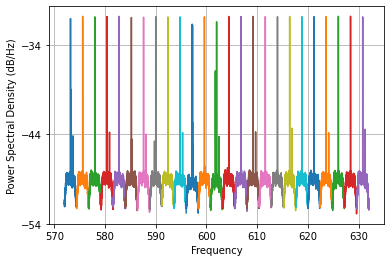

In [32]:
f_min = 572e6
f_max = 632e6
    
    
canales ={

        'canal 31 - Libre 1': [572.01,572.49,'libre'],
        'canal 31 - Video': [572.50,574.00,'usado'],
        'canal 31 - Libre 2': [574.01,575.920,'libre'],
        'canal 31 - Armonicos': [575.925,577.25,'usado'],
        'canal 31 - Libre 3': [575.3,577.69,'libre'],
        'canal 31 - Audio': [577.7,577.81,'usado'],
        'canal 31 - Libre 4': [577.82,578.00,'libre'],

        'canal 32 - Libre 1': [578.01,584.00,'libre'],

        'canal 33 - Libre 1': [584.01,584.49,'libre'],
        'canal 33 - Video': [584.50,586.00,'usado'],
        'canal 33 - Libre 2': [586.01,588.649,'libre'],
        'canal 33 - Armonicos': [588.65,589.10,'usado'],
        'canal 33 - Libre 3': [589.2,589.68,'libre'],
        'canal 33 - Audio': [589.69,589.88750,'usado'],
        'canal 33 - Libre 4': [589.9,590.00,'libre'],

        'canal 34 - Libre 1': [590.01,590.34,'libre'],
        'canal 34 - Armonicos': [590.35,590.45,'usado'],
        'canal 34 - Libre 2': [590.46,596.000,'libre'],

        'canal 35 - Libre 1': [596.01,596.24,'libre'],
        'canal 35 - Video': [596.25,598.55,'usado'],
        'canal 35 - Libre 2': [598.56,599.95,'libre'],
        'canal 35 - Armonicos': [599.96,601.10,'usado'],
        'canal 35 - Libre 3': [601.2,601.68,'libre'],
        'canal 35 - Audio': [601.69,601.8250,'usado'],
        'canal 35 - Libre 4': [601.9,602.00,'libre'],

        'canal 36 - Libre 1': [602.01,608.00,'libre'],

        'canal 37 - Libre 1': [608.01,614.00,'libre'],

        'canal 38 - Libre 1': [614.01,620.00,'libre'],

        'canal 39 - Libre 1': [620.01,623.69,'libre'],
        'canal 39 - Armonicos': [623.7,623.9,'usado'],
        #'canal 39 - Libre 2': [624.00,624.00,'libre'],


        }  
    #Espectro: Diccionario con los datos de las frecuencias y sus Potencias
    #Espectro: Diccionario con los datos de las frecuencias y sus Potencias
datos, espuria , descision =procesamiento(f_min,f_max,canales)      #descion = 1 hay espuria, 0 no hay espuria
    #espectro = procesamiento_diccionarios(datos)
print(datos)

Frecuencia    629.600000
Potencia      -30.730973
Name: 1531, dtype: float64
629.6
-30.730973312823696
{'Frecuencia': 629.6, 'Potencia': -30.730973312823696}
No hay interferencia en el canal 40 - Libre 1
Frecuencia    634.400000
Potencia      -30.794329
Name: 1019, dtype: float64
634.4
-30.79432915468172
{'Frecuencia': 634.4, 'Potencia': -30.79432915468172}
No hay interferencia en el canal 41 - Libre 1
Frecuencia    641.600000
Potencia      -30.754364
Name: 1531, dtype: float64
641.6
-30.754364379075533
{'Frecuencia': 641.6, 'Potencia': -30.754364379075533}
No hay interferencia en el canal 42 - Libre 1
Frecuencia    646.400000
Potencia      -30.817697
Name: 1019, dtype: float64
646.4
-30.817697340877572
{'Frecuencia': 646.4, 'Potencia': -30.817697340877572}
No hay interferencia en el canal 43 - Libre 1
Frecuencia    651.20000
Potencia      -30.72299
Name: 507, dtype: float64
651.2
-30.722989768258365
{'Frecuencia': 651.2, 'Potencia': -30.722989768258365}
No hay interferencia en el cana

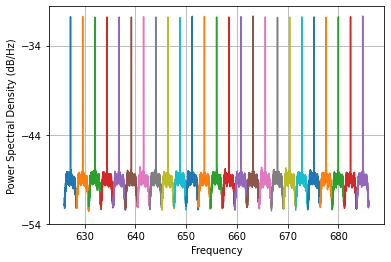

In [33]:
f_min = 626e6
f_max = 686e6
   
canales ={

        'canal 40 - Libre 1': [626.01,632.00,'libre'],
        'canal 41 - Libre 1': [632.01,638.00,'libre'],
        'canal 42 - Libre 1': [638.01,644.00,'libre'],
        'canal 43 - Libre 1': [644.01,650.00,'libre'],
        'canal 44 - Libre 1': [650.01,656.00,'libre'],
        'canal 45 - Libre 1': [656.01,662.00,'libre'],
        'canal 46 - Libre 1': [662.01,668.00,'libre'],
        'canal 47 - Libre 1': [668.01,674.00,'libre'],
        'canal 48 - Libre 1': [674.01,680.00,'libre'],
        'canal 49 - Libre 1': [680.01,686.00,'libre'],

        }  
    

    #Espectro: Diccionario con los datos de las frecuencias y sus Potencias
datos, espuria , descision =procesamiento(f_min,f_max,canales)      #descion = 1 hay espuria, 0 no hay espuria
    #espectro = procesamiento_diccionarios(datos)
print (datos)